# Project Background#
The primary objective of this project is to create a publicly available tool to assist consumers in making informed decisions when choosing credit cards. The project is inspired by the initiative "Promoting Competition in the Credit Card Market," developed by the Census Innovation Labs and the Consumer Financial Protection Bureau (CFPB). This tool aims to address several key challenges faced by consumers, including the lack of transparency in advertised interest rates and the potential negative impact on credit scores from applying for multiple cards. The tool will focus on presenting a comprehensive analysis of credit card options (TCCP dataset), emphasizing the total cost of ownership and integrating insights from CFPB consumer complaints data to highlight consumers' experiences and perspectives.

##Tool Synopsis and Functional Overview
###1. Filtering Dropdowns:###
- *Functionality:* The tool includes multiple dropdown menus that allow users to filter credit cards based on specific criteria such as credit score ranges, state availability, card features, services, and rewards. Users can select multiple options within each category to narrow down their search.
- *Utility for Consumers:* This feature helps consumers quickly filter out credit cards that do not meet their basic requirements or preferences, making the comparison process more efficient. For instance, a user looking for cards available in their state with cashback rewards can easily isolate relevant options, unlike many other tools that may not offer such detailed filtering.

###2. Visualizations:###
- *Functionality:* The tool provides various visualizations, including histograms for different APR ranges (Purchase APR, Advance APR) and fee distributions. These graphs can be tailored to display specific data based on the user's selections in the filtering dropdowns.
- *Utility for Consumers:* Visualizations offer an intuitive way to understand the distribution and range of APRs and fees across the filtered set of credit cards. This feature is particularly useful for consumers who prefer graphical insights over textual data, providing a quick snapshot of potential costs and APR ranges that may not be as easily digestible in list formats on other platforms.

###3. Sorting Function:###
- *Functionality:* Users can sort the filtered dataset by various metrics, such as 'Advance APR median', 'Purchase APR median', 'Cumulative Yearly Fee', etc. This sorting can be done using dropdown menus, allowing for primary and secondary sorting criteria.
- *Utility for Consumers:* This feature is crucial for users looking to prioritize certain factors over others. For example, consumers concerned with finding the lowest APR can sort by 'Advance APR median' and then further sort by 'Cumulative Yearly Fee' to identify the most cost-effective cards. This dual sorting capability offers a more nuanced approach than most basic sorting tools on comparison websites.

###4. Detailed Card Information Output:###
- *Functionality:* The tool provides a detailed output of selected credit cards, displaying comprehensive information such as APRs, fees, sentiment star ratings, and other key metrics. This output can be viewed for the top-ranked cards based on the user's filtering and sorting choices.
- *Utility for Consumers:* This feature gives users an in-depth look at individual cards, including specifics like 'Sentiment Star Rating' based on consumer complaints, detailed fee structures, and APR breakdowns. Unlike many other tools that may only provide a high-level summary, this detailed view allows consumers to make well-informed decisions by understanding the full scope of each card's costs and benefits. Additionally, providing sentiment analysis adds a unique layer of consumer feedback often missing in other comparison tools.

In [3]:
import pandas as pd
data = pd.read_csv('merged_data (2).csv')

In [4]:
# Display the first few rows of the DataFrame
print(data.head())

         Institution Name                            Product Name  \
0  1ST FINANCIAL BANK USA      1st Financial Bank USA credit card   
1   ADVANTIS CREDIT UNION  Signature Cashback Rewards Credit Card   
2               ALLY BANK                    Platinum+ Mastercard   
3               ALLY BANK              Ally Platinum Mastercard_1   
4               ALLY BANK              Ally Platinum Mastercard_2   

           Report Date Availability of Credit Card Plan State  \
0  2023-06-30 00:00:00                         National   NaN   
1  2023-06-30 00:00:00                         Regional   NaN   
2  2023-06-30 00:00:00                         National   NaN   
3  2023-06-30 00:00:00                         National   NaN   
4  2023-06-30 00:00:00                         National   NaN   

  State (Multiple) Pertains to Specific Counties? Requirements for Opening  \
0              NaN                            NaN                       No   
1           OR; WA                    

##Data Cleaning Steps##
####Missing Data Handling:####

- Issue: Missing values were found in several important columns, such as APR rates and fees.
- Action: Imputed missing values using averages or specific rules, ensuring consistency and completeness in the data for accurate analysis.

####Data Type Correction:####
- Issue: Columns had inconsistent data types, such as numeric fields stored as strings.
- Action: Converted columns to appropriate data types (e.g., from strings to floats or integers).

####Normalization of Values:####
- Issue: Inconsistent scales in some columns, like 'Average Negative Sentiment.'
- Action: Normalized values to a standard scale (0-5 star rating) and inverting where necessary (higher scores indicating better sentiment).

####Handling Duplicates:####
- Issue: Duplicate entries in the dataset.
- Action: Identified and removed duplicate rows based on unique identifiers or key attributes.
Reason: Prevented redundancy and ensured the uniqueness of data points, leading to more accurate analysis and results.

####Feature Engineering:####
- Issue: Key metrics such as 'Sentiment Star Rating' were not directly available.
- Action: Created new columns like 'Sentiment Star Rating' by deriving values from existing columns (e.g., normalizing sentiment scores).

####Text Standardization:####
- Issue: Inconsistent text data, such as varying capitalization and formats in categorical fields.
- Action: Standardized text formats (e.g., converting to lowercase, consistent naming conventions).


##Feature Engineering Steps##

####Creation of Binary Columns for Categorical Features:####

- Issue: Some categorical features were presented as lists or strings, making it difficult to perform direct comparisons or aggregations.
- Action: Converted categorical strings into binary columns (e.g., features like 'Chip card', 'Contactless Payments', etc.) indicating the presence (1) or absence (0) of each feature for a given credit card.

####Sentiment Star Rating:####
- Issue: Sentiment data from consumer complaints was raw and not directly interpretable.
- Action: Created a 'Sentiment Star Rating' column by normalizing the 'Average Negative Sentiment' scores to a 0-5 scale, where a lower score indicates better consumer sentiment. This was inverted from the original data to ensure that higher star ratings corresponded with more positive sentiment.

####Aggregating and Normalizing APR Values:####
- Issue: The APR columns had varying levels of granularity and sometimes missing median values.
- Action: Filled missing APR values using the average of the available minimum and maximum values, and standardized these into easily comparable metrics (min, median, max).

####Consolidation of Fees into Cumulative Metrics:####
- Issue: Fees were spread across multiple columns with varying formats and units (e.g., dollars, percentages).
- Action: Consolidated these into cumulative metrics such as 'Balance Transfer Fees Cumulative', 'Cash Advance Fees Cumulative', etc., which summarize the total fees a consumer might expect.

####Standardization of Text Data:####
- Issue: Inconsistent formatting in textual data fields (e.g., capitalization, spacing).
- Action: Standardized text formats across the dataset, ensuring consistent capitalization, removing extra spaces, and correcting typographical errors.

####Integration of External Consumer Complaint Data:####
- Issue: External data sources needed to be integrated to provide comprehensive consumer insights.
- Action: Merged consumer complaint data with the main dataset, extracting relevant metrics such as 'Average Negative Sentiment'.

In [5]:
#convert 9.98 to 0.098
data['Purchase APR min']= data['Purchase APR min'].replace(9.98, 0.098)
data = data[data['Intro APR max'] != 0.3024]

In [6]:
# create binary columns for credit score ranges for later analysis.
#Will allow customers to speficy their credit range and search cards available to them
# Define the possible credit score ranges
credit_score_ranges = [
    'No credit score',
    'Credit score 619 or less',
    'Credit scores from 620 to 719',
    'Credit score of 720 or greater'
]

#No credit score; Credit scores from 620 to 719; Credit score of 720 or greater
# Initialize binary columns for each credit score range
for score_range in credit_score_ranges:
    data[score_range] = 0

# Populate the binary columns
for index, row in data.iterrows():
    targeted_credit_tiers = row['Targeted Credit Tiers']
    for score_range in credit_score_ranges:
        if score_range in targeted_credit_tiers:
            data.at[index, score_range] = 1


In [7]:
import numpy as np
data.loc[data['Product Name'] == 'Hawaiian World Elite Mastercard', 'Advance APR median'] = \
    data.loc[data['Product Name'] == 'Hawaiian World Elite Mastercard', 'Advance APR median'].replace(0, np.nan)


In [8]:
# look at all unique strings in the Card Features column
unique_features = set()
for features in data['Card Features'].dropna():
    for feature in features.split(';'):
        unique_features.add(feature.strip())

# Convert the set to a sorted list
unique_features = sorted(unique_features)

# Print all unique features
for feature in unique_features:
    print(feature)

Chip card
Contactless Payments
Fee-free foreign transactions
Mobile wallet provisioning (for example, Apple Pay)
Other


In [9]:
data['Card Features'].fillna('No_features', inplace=True)

In [10]:
#This will replace all 'Other' strings in the Card Features columns with 'Other_features' beucause we will turn this into its own column
#later when we convert it to dummies.  Other columns that will be converted to duimmy columns also have 'Other' categories so we need to
#replace them with 'Other_...' that seperates them from one another
def replace_other_features(row):
    if pd.notna(row):
        features = row.split('; ')
        features = ['Other_features' if feature == 'Other' else feature for feature in features]
        return '; '.join(features)
    return row

# Apply the function to the 'Card Features' column
data['Card Features'] = data['Card Features'].apply(replace_other_features)

# Save the updated dataset
updated_file_path = 'path_to_save_updated_creditcard_data.xlsx'
data.to_excel(updated_file_path, index=False)

In [11]:
#check that the code above accomplished the intended task
unique_features = set()
for features in data['Card Features'].dropna():
    for feature in features.split(';'):
        unique_features.add(feature.strip())

# Convert the set to a sorted list
unique_features = sorted(unique_features)

# Print all unique features
for feature in unique_features:
    print(feature)

Chip card
Contactless Payments
Fee-free foreign transactions
Mobile wallet provisioning (for example, Apple Pay)
No_features
Other_features


In [12]:
# This code seperates the Card Features column into 5 columns with binary outputs for each of the card features listed below. this will amke it easier to analyze
# i have chosen to leave the Other Card Features column out of our analysis as features vary greatly and it would add too many columns to our dataset
# the entity collecting TCCP data should make a more structured method for card providers to imput features into the dataset.
# a true production tool would include these OTHER features in some form
# Define the possible card features
card_features = [
    'Chip card',
    'Contactless Payments',
    'Fee-free foreign transactions',
    'Mobile wallet provisioning (for example, Apple Pay)',
    'Other_features',
    'No_features'
]

# Initialize binary columns for each card feature
for feature in card_features:
    data[feature] = 0

# Populate the binary columns
for index, row in data.iterrows():
    card_features_list = row['Card Features']
    if pd.notna(card_features_list):
        for feature in card_features:
            if feature in card_features_list:
                data.at[index, feature] = 1

# Save the updated dataset
data.to_excel(updated_file_path, index=False)


# Services  Column Cleaning/Engineering#

In [13]:
#lets look at all the possible card "Services"
unique_features = set()
for features in data['Services'].dropna():
    for feature in features.split(';'):
        unique_features.add(feature.strip())

# Convert the set to a sorted list
unique_features = sorted(unique_features)

# Print all unique features
for feature in unique_features:
    print(feature)

Access to Free Credit Scores
Automobile rental insurance
Credit card registration
Debt cancellation coverage
Discounts on purchases of goods and services (non travel related)
Extension on manufacturer’s warranty
Other


In [14]:
data['Services'].fillna('No_Services', inplace=True)

In [15]:
#This will replace all 'Other' strings in the Services columns with 'Other_features' beucause we will turn this into its own column
#later when we convert it to dummies.  Other columns that will be converted to duimmy columns also have 'Other' categories so we need to
#replace them with 'Other_...' that seperates them from one another
def replace_other_features(row):
    if pd.notna(row):
        features = row.split('; ')
        features = ['Other_services' if feature == 'Other' else feature for feature in features]
        return '; '.join(features)
    return row

# Apply the function to the 'Card Features' column
data['Services'] = data['Services'].apply(replace_other_features)

# Save the updated dataset
updated_file_path = 'path_to_save_updated_creditcard_data.xlsx'
data.to_excel(updated_file_path, index=False)

In [16]:
#lets look at all the possible card "Services" after the change to make sure it worked
unique_features = set()
for features in data['Services'].dropna():
    for feature in features.split(';'):
        unique_features.add(feature.strip())

# Convert the set to a sorted list
unique_features = sorted(unique_features)

# Print all unique features
for feature in unique_features:
    print(feature)

Access to Free Credit Scores
Automobile rental insurance
Credit card registration
Debt cancellation coverage
Discounts on purchases of goods and services (non travel related)
Extension on manufacturer’s warranty
No_Services
Other_services


In [17]:
# This code chunk combines the state, multiple state columns into one column containing all states where that card is available (
    #maybe should get rid of 'region' column also? prob not because people want to know where their card is available outside of their home state

# List of all state abbreviations
all_states = [
    'AA', 'AE', 'AK', 'AL', 'AP', 'AR', 'AS', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', 'FM',
    'GA', 'GU', 'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME', 'MH', 'MI',
    'MN', 'MO', 'MP', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM', 'NV', 'NY', 'OH', 'OK',
    'OR', 'PA', 'PR', 'PW', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VA', 'VI', 'VT', 'WA', 'WI', 'WV', 'WY'
]

# Function to combine state columns
def combine_states(row):
    states = set()
    if pd.notna(row['State']):
        states.update(row['State'].split(';'))
    if pd.notna(row['State (Multiple)']):
        states.update(row['State (Multiple)'].split(';'))
    if not states:
        states.update(all_states)
    return '; '.join(sorted(states))

# Combine 'State' and 'State (Multiple)' into a new column 'Available States'
data['Available States'] = data.apply(combine_states, axis=1)

# Save the updated dataset
data.to_excel(updated_file_path, index=False)

data.drop(columns=['State', 'State (Multiple)', 'Pertains to Specific Counties?'], inplace=True)
print(data['Available States'])

0      AA; AE; AK; AL; AP; AR; AS; AZ; CA; CO; CT; DC...
1                                                 WA; OR
2      AA; AE; AK; AL; AP; AR; AS; AZ; CA; CO; CT; DC...
3      AA; AE; AK; AL; AP; AR; AS; AZ; CA; CO; CT; DC...
4      AA; AE; AK; AL; AP; AR; AS; AZ; CA; CO; CT; DC...
                             ...                        
643    AA; AE; AK; AL; AP; AR; AS; AZ; CA; CO; CT; DC...
644                                                   WA
645    AA; AE; AK; AL; AP; AR; AS; AZ; CA; CO; CT; DC...
646    AA; AE; AK; AL; AP; AR; AS; AZ; CA; CO; CT; DC...
647                                          UT;  WY; ID
Name: Available States, Length: 647, dtype: object


In [18]:
# This splits the Services column up into individual columns for each service and gives a binary 0 or 1 for if that row has the service or not
# OTHER services and columns are once again ignored as they very too much between card providers to be analyzed as a group
# Define the possible services
services = [
    'Access to Free Credit Scores',
    'Automobile rental insurance',
    'Credit card registration',
    'Debt cancellation coverage',
    'Discounts on purchases of goods and services (non travel related)',
    'Extension on manufacturer’s warranty',
    'Other_services',
    'No_Services'
]

# Initialize binary columns for each service
for service in services:
    data[service] = 0

# Populate the binary columns
for index, row in data.iterrows():
    services_list = row['Services']
    if pd.notna(services_list):
        for service in services:
            if service in services_list:
                data.at[index, service] = 1

data.to_excel(updated_file_path, index=False)



# Rewards column data Cleaning/Engineering #

In [19]:
#lets look at all the possible card "Rewards"
unique_features = set()
for features in data['Rewards'].dropna():
    for feature in features.split(';'):
        unique_features.add(feature.strip())

# Convert the set to a sorted list
unique_features = sorted(unique_features)

# Print all unique features
for feature in unique_features:
    print(feature)

Cashback rewards
Other rewards
Travel-related rewards


In [20]:
data['Rewards'].fillna('No_rewards', inplace=True)

In [21]:
#This splits the Services column up into individual columns for each service and gives a binary 0 or 1 for if that row has the service or not
# OTHER rewards and columns are once again ignored as they very too much between card providers to be analyzed as a group
# Define the possible services
rewards = [
    'Cashback rewards',
    'Other rewards',
    'Travel-related rewards',
    'No_rewards'
]

# Initialize binary columns for each service
for reward in rewards:
    data[reward] = 0

# Populate the binary columns
for index, row in data.iterrows():
    rewards_list = row['Rewards']
    if pd.notna(rewards_list):
        for reward in rewards:
            if reward in rewards_list:
                data.at[index, reward] = 1

data.to_excel(updated_file_path, index=False)

# Opening Requirements #

In [22]:
#lets look at all the possible card 'Requirements for Opening Types'
unique_features = set()
for features in data['Requirements for Opening Types'].dropna():
    for feature in features.split(';'):
        unique_features.add(feature.strip())

# Convert the set to a sorted list
unique_features = sorted(unique_features)

# Print all unique features
for feature in unique_features:
    print(feature)

Geographic Restrictions Beyond Place of Residence
Other. Please Describe:
Professional Affiliation


In [23]:
data['Requirements for Opening Types'].fillna('No_opening_requirements', inplace=True)

In [24]:
#this splits the opening requirements column up into individual columns for each service and gives a binary 0 or 1 for if that row has the service or not
# there are many other specific requirements that would need to be encoded in a formal tool!!!!!
# Define the possible opening requirement types
opening_requirements = [
    'Geographic Restrictions Beyond Place of Residence',
    'Other. Please Describe:',
    'Professional Affiliation',
    'No_opening_requirements'
]

# Initialize binary columns for each opening requirement type
for requirement in opening_requirements:
    data[requirement] = 0

# Populate the binary columns
for index, row in data.iterrows():
    requirements_list = row['Requirements for Opening Types']
    if pd.notna(requirements_list):
        for requirement in opening_requirements:
            if requirement in requirements_list:
                data.at[index, requirement] = 1

# Save the updated dataset
data.to_excel(updated_file_path, index=False)


# Fee columns data cleaning

In [25]:
#impute Periodic Fee Type column with 'none' string in place of NANs
 # Impute NaN values in the 'Periodic Fee Type' column with 'None'
data['Periodic Fee Type'].fillna('None', inplace=True)

# Save the updated dataset
data.to_excel(updated_file_path, index=False)

# Print the updated 'Periodic Fee Type' column to verify the changes
print(data['Periodic Fee Type'].head())


0    Annual
1      None
2      None
3      None
4      None
Name: Periodic Fee Type, dtype: object


In [26]:
#Impute nans in 'Balance Transfer Fee (%)' and 'Minimum Balance Transfer Fee Amount' columns with 0 int
data['Minimum Balance Transfer Fee Amount'].fillna(0, inplace=True)
data['Balance Transfer Fee (%)'].fillna(0, inplace=True)

# Save the updated dataset
data.to_excel(updated_file_path, index=False)

In [27]:
# List of columns to fill NaNs with 0
columns_to_fill = [
    'Cash Advance Fee ($)',
    'Cash Advance Fee (%)',
    'Minimum Cash Advance Fee Amount',
    'Foreign Transaction Fee (%)',
    'Late Fee ($)',
    'Late Fee Six Month Billing Cycle',
    'Over Limit Fee ($)',
    'Annual Fee',
    'Monthly Fee',
    'Weekly Fee',
    'Balance Transfer Fee ($)',
    'Balance Transfer Fee (%)',
    'Cash Advance Fee ($)',
    'Cash Advance Fee (%)',
    'Minimum Cash Advance Fee Amount',
    'Foreign Transaction Fee (%)',
    'Late Fee ($)',
    'Minimum Balance Transfer Fee Amount',
]

# Impute NaN values in the specified columns with 0
for column in columns_to_fill:
    data[column].fillna(0, inplace=True)



In [28]:
# Create the new column 'Cumulative Yearly Fee'
data['Cumulative Yearly Fee'] = 0

# Define a function to calculate the cumulative yearly fee
def calculate_cumulative_yearly_fee(row):
    annual_fee = row['Annual Fee'] if pd.notna(row['Annual Fee']) else 0
    monthly_fee = (row['Monthly Fee'] * 12) if pd.notna(row['Monthly Fee']) else 0
    weekly_fee = (row['Weekly Fee'] * 52) if pd.notna(row['Weekly Fee']) else 0
    return annual_fee + monthly_fee + weekly_fee

# Apply the function to each row in the DataFrame
data['Cumulative Yearly Fee'] = data.apply(calculate_cumulative_yearly_fee, axis=1)



In [29]:
# Print the columns for the row with "Fortiva MasterCard, Aspire MasterCard" in the Product Name column
specific_row = data[data['Product Name'] == "Fortiva MasterCard, Aspire MasterCard"]
print(specific_row[['Product Name', 'Annual Fee', 'Monthly Fee', 'Weekly Fee', 'Cumulative Yearly Fee']])

                             Product Name  Annual Fee  Monthly Fee  \
67  Fortiva MasterCard, Aspire MasterCard       175.0         12.5   

    Weekly Fee  Cumulative Yearly Fee  
67         0.0                  325.0  


In [30]:
# Define the columns to drop (they have no data so are just taking up space)
columns_to_drop = [
    'Purchase Transaction Fees',
    'Purchase Transaction Fee Type',
    'Purchase Transaction Fee ($)',
    'Purchase Transaction Fee (%)',
    'Minimum Purchase Transaction Fee Amount',
    'Purchase Transaction Fee Calculation'
]

# Drop the specified columns
data.drop(columns=columns_to_drop, inplace=True)

In [31]:
# Define the columns to drop (they have no data so are just taking up space)
columns_to_drop = [
    'Purchase APR Balance Tier 1',
    'Purchase APR Tier 1 From Balance',
    'Purchase APR Tier 1 to Balance',
    'Purchase APR Balance Tier 2',
    'Purchase APR Tier 2 From Balance',
    'Purchase APR Tier 2 To Balance',
    'Purchase APR Balance Tier 3',
    'Purchase APR Tier 3 From Balance',
    'Purchase APR Tier 3 To Balance',
    'Purchase APR Balance Tier 4',
    'Purchase APR Tier 4 From Balance',
    'Purchase APR Tier 4 To Balance'
]

# Drop the specified columns
data.drop(columns=columns_to_drop, inplace=True)

In [32]:
def combine_balance_transfer_fees(row):
    parts = []

    if pd.notna(row['Balance Transfer Fee ($)']):
        parts.append(f"Balance Transfer fee: {row['Balance Transfer Fee ($)']}$")
    if pd.notna(row['Balance Transfer Fee (%)']):
        parts.append(f"Percentage Balance Transfer fee: {row['Balance Transfer Fee (%)']}%")
    if pd.notna(row['Minimum Balance Transfer Fee Amount']):
        parts.append(f"Minimum Balance Transfer fee: {row['Minimum Balance Transfer Fee Amount']}$")

    return '  ;  '.join(parts) if parts else pd.NA

# Apply the function to each row in the DataFrame
data['Balance Transfer Fees Cumulative'] = data.apply(combine_balance_transfer_fees, axis=1)

In [33]:
def combine_cash_advance_fees(row):
    parts = []

    if pd.notna(row['Cash Advance Fee ($)']):
        parts.append(f"Dollar Cash Advance fee: {row['Cash Advance Fee ($)']}$")
    if pd.notna(row['Cash Advance Fee (%)']):
        parts.append(f"Percentage Cash Advance fee: {row['Cash Advance Fee (%)']}%")
    if pd.notna(row['Minimum Cash Advance Fee Amount']):
        parts.append(f"Minimum Cash Advance fee: {row['Minimum Cash Advance Fee Amount']}$")

    return '  ;  '.join(parts) if parts else pd.NA

# Apply the function to each row in the DataFrame
data['Cash Advance Fees Cumulative'] = data.apply(combine_cash_advance_fees, axis=1)

In [34]:
def combine_foreign_transaction_fees(row):
    parts = []

    if pd.notna(row['Foreign Transaction Fee ($)']):
        parts.append(f"Foreign Transaction Fee: {row['Foreign Transaction Fee ($)']}$")
    if pd.notna(row['Foreign Transaction Fee (%)']):
        parts.append(f"Percentage Foreign Transaction Fee: {row['Foreign Transaction Fee (%)']}%")
    if pd.notna(row['Minimum Foreign Transaction Fee Amount']):
        parts.append(f"Minimum Foreign Transaction Fee: {row['Minimum Foreign Transaction Fee Amount']}$")

    return '  ;  '.join(parts) if parts else pd.NA

# Apply the function to each row in the DataFrame
data['Foreign Transaction Fees Cumulative'] = data.apply(combine_foreign_transaction_fees, axis=1)

In [35]:
def combine_foreign_transaction_fees(row):
    parts = []
    if pd.notna(row['Late Fee ($)']):
        parts.append(f"First Late Fee Charge: {row['Late Fee ($)']}$")
    if pd.notna(row['Late Fee Six Month Billing Cycle']):
        parts.append(f"late fees charged within six billing cycles of a previous late fee: {row['Late Fee Six Month Billing Cycle']}$")
    if pd.notna(row['Late Fee Policy Details']):
        parts.append(f"Other LAte Fee Policy: {row['Late Fee Policy Details']}")
    return '  ;  '.join(parts) if parts else pd.NA

# Apply the function to each row in the DataFrame
data['Late Fee Cumulative'] = data.apply(combine_foreign_transaction_fees, axis=1)

In [36]:
def combine_over_limit_types(row):
    parts = []
    if pd.notna(row['Over Limit Fee Types']):
        parts.append(f"Type: {row['Over Limit Fee Types']}$")
    if pd.notna(row['Over Limit Fee ($)']):
        parts.append(f"Over Limit Fee ($): {row['Over Limit Fee ($)']}$")
    if pd.notna(row['Overlimit Fee Detail']):
        parts.append(f"Details: {row['Overlimit Fee Detail']}")
    return '  ;  '.join(parts) if parts else pd.NA

# Apply the function to each row in the DataFrame
data['Over Limit Fee Cumulative'] = data.apply(combine_over_limit_types, axis=1)

In [37]:
def combine_other_fee_types(row):
    parts = []
    if pd.notna(row['Other Fee Name']):
        parts.append(f"Other Fee name: {row['Other Fee Name']}$")
    if pd.notna(row['Other Fee Amount']):
        parts.append(f"Amount ($): {row['Other Fee Amount']}$")
    if pd.notna(row['Other Fee Explanation']):
        parts.append(f"Details: {row['Other Fee Explanation']}")
    return '  ;  '.join(parts) if parts else pd.NA

# Apply the function to each row in the DataFrame
data['Other Fee Cumulative'] = data.apply(combine_other_fee_types, axis=1)

In [38]:
def combine_other_fee2_types(row):
    parts = []
    if pd.notna(row['Other Fee Name 2']):
        parts.append(f"Other Fee 2: {row['Other Fee Name 2']}$")
    if pd.notna(row['Other Fee Amount 2']):
        parts.append(f"Amount ($): {row['Other Fee Amount 2']}$")
    if pd.notna(row['Other Fee Explanation 2']):
        parts.append(f"Details: {row['Other Fee Explanation 2']}")
    return '  ;  '.join(parts) if parts else pd.NA

# Apply the function to each row in the DataFrame
data['Other Fee Cumulative 2'] = data.apply(combine_other_fee2_types, axis=1)

In [39]:
def combine_other_fee3_types(row):
    parts = []
    if pd.notna(row['Other Fee Name 3']):
        parts.append(f"Other Fee 3: {row['Other Fee Name 3']}$")
    if pd.notna(row['Other Fee Amount 3']):
        parts.append(f"Amount ($): {row['Other Fee Amount 3']}$")
    if pd.notna(row['Other Fee Explanation 3']):
        parts.append(f"Details: {row['Other Fee Explanation 3']}")
    return '  ;  '.join(parts) if parts else pd.NA

# Apply the function to each row in the DataFrame
data['Other Fee Cumulative 3'] = data.apply(combine_other_fee3_types, axis=1)

In [40]:
def combine_other_fee4_types(row):
    parts = []
    if pd.notna(row['Other Fee Name 4']):
        parts.append(f"Other Fee 4: {row['Other Fee Name 4']}$")
    if pd.notna(row['Other Fee Amount 4']):
        parts.append(f"Amount ($): {row['Other Fee Amount 4']}$")
    if pd.notna(row['Other Fee Explanation 3']):
        parts.append(f"Details: {row['Other Fee Explanation 4']}")
    return '  ;  '.join(parts) if parts else pd.NA

# Apply the function to each row in the DataFrame
data['Other Fee Cumulative 4'] = data.apply(combine_other_fee4_types, axis=1)

In [41]:
def combine_other_fee5_types(row):
    parts = []
    if pd.notna(row['Other Fee Name 5']):
        parts.append(f"Other Fee 5: {row['Other Fee Name 5']}$")
    if pd.notna(row['Other Fee Amount 5']):
        parts.append(f"Amount ($): {row['Other Fee Amount 5']}$")
    if pd.notna(row['Other Fee Explanation 5']):
        parts.append(f"Details: {row['Other Fee Explanation 5']}")
    return '  ;  '.join(parts) if parts else pd.NA

# Apply the function to each row in the DataFrame
data['Other Fee Cumulative 5'] = data.apply(combine_other_fee5_types, axis=1)

In [42]:
# Define the function to combine 'Other Periodic Fee Name', 'Other Periodic Fee Amount', 'Other Periodic Fee Frequency'
def combine_other_periodic_fees(row):
    if pd.notna(row['Other Periodic Fee Name']) and pd.notna(row['Other Periodic Fee Amount']) and pd.notna(row['Other Periodic Fee Frequency']):
        return f"{row['Other Periodic Fee Name']}: {row['Other Periodic Fee Amount']}: {row['Other Periodic Fee Frequency']}"
    else:
        return pd.NA

# Apply the function to each row in the DataFrame
data['Other Periodic Fees Cumulative'] = data.apply(combine_other_periodic_fees, axis=1)

In [43]:
def fill_purchase_apr(row):
    poor, good, great = row['Purchase APR poor'], row['Purchase APR good'], row['Purchase APR great']

    # Check if all three columns already have values
    if pd.notna(poor) and pd.notna(good) and pd.notna(great):
        return row

    # If only one of the three columns has a value, fill the other 2 with the same value
    if pd.notna(poor) and pd.isna(good) and pd.isna(great):
        row['Purchase APR good'] = row['Purchase APR great'] = poor
    elif pd.isna(poor) and pd.notna(good) and pd.isna(great):
        row['Purchase APR poor'] = row['Purchase APR great'] = good
    elif pd.isna(poor) and pd.isna(good) and pd.notna(great):
        row['Purchase APR poor'] = row['Purchase APR good'] = great

    # If two of the three columns have values, fill the missing column with the value to the right
    elif pd.notna(poor) and pd.notna(good) and pd.isna(great):
        row['Purchase APR great'] = good
    elif pd.notna(poor) and pd.isna(good) and pd.notna(great):
        row['Purchase APR good'] = great
    elif pd.isna(poor) and pd.notna(good) and pd.notna(great):
        row['Purchase APR poor'] = good

    return row

# Apply the function to each row in the DataFrame
data = data.apply(fill_purchase_apr, axis=1)

In [44]:
def fill_purchase_apr_range(row):
    min_apr, median_apr, max_apr = row['Purchase APR min'], row['Purchase APR median'], row['Purchase APR max']

    # Check if all three columns already have values
    if pd.notna(min_apr) and pd.notna(median_apr) and pd.notna(max_apr):
        return row

    # If only one of the three columns has a value, fill the other 2 with the same value
    if pd.notna(min_apr) and pd.isna(median_apr) and pd.isna(max_apr):
        row['Purchase APR median'] = row['Purchase APR max'] = min_apr
    elif pd.isna(min_apr) and pd.notna(median_apr) and pd.isna(max_apr):
        row['Purchase APR min'] = row['Purchase APR max'] = median_apr
    elif pd.isna(min_apr) and pd.isna(median_apr) and pd.notna(max_apr):
        row['Purchase APR min'] = row['Purchase APR median'] = max_apr

    # If two of the three columns have values, fill the missing column with the appropriate value
    elif pd.notna(min_apr) and pd.notna(median_apr) and pd.isna(max_apr):
        row['Purchase APR max'] = median_apr
    elif pd.notna(min_apr) and pd.isna(median_apr) and pd.notna(max_apr):
        row['Purchase APR median'] = (min_apr + max_apr) / 2
    elif pd.isna(min_apr) and pd.notna(median_apr) and pd.notna(max_apr):
        row['Purchase APR min'] = median_apr

    return row

# Apply the function to each row in the DataFrame
data = data.apply(fill_purchase_apr_range, axis=1)

In [45]:
# Function to fill in 'Intro APR poor', 'Intro APR good', and 'Intro APR great' columns
def fill_intro_apr(row):
    poor, good, great = row['Intro APR poor'], row['Intro APR good'], row['Intro APR great']

    # Check if all three columns already have values
    if pd.notna(poor) and pd.notna(good) and pd.notna(great):
        return row

    # If only one of the three columns has a value, fill the other 2 with the same value
    if pd.notna(poor) and pd.isna(good) and pd.isna(great):
        row['Intro APR good'] = row['Intro APR great'] = poor
    elif pd.isna(poor) and pd.notna(good) and pd.isna(great):
        row['Intro APR poor'] = row['Intro APR great'] = good
    elif pd.isna(poor) and pd.isna(good) and pd.notna(great):
        row['Intro APR poor'] = row['Intro APR good'] = great

    # If two of the three columns have values, fill the missing column with the value to the right
    elif pd.notna(poor) and pd.notna(good) and pd.isna(great):
        row['Intro APR great'] = good
    elif pd.notna(poor) and pd.isna(good) and pd.notna(great):
        row['Intro APR good'] = great
    elif pd.isna(poor) and pd.notna(good) and pd.notna(great):
        row['Intro APR poor'] = good

    return row

# Apply the function to each row in the DataFrame
data = data.apply(fill_intro_apr, axis=1)

In [46]:
def fill_intro_apr_range(row):
    min_apr, median_apr, max_apr = row['Intro APR min'], row['Intro APR median'], row['Intro APR max']

    # Check if all three columns already have values
    if pd.notna(min_apr) and pd.notna(median_apr) and pd.notna(max_apr):
        return row

    # If only one of the three columns has a value, fill the other 2 with the same value
    if pd.notna(min_apr) and pd.isna(median_apr) and pd.isna(max_apr):
        row['Intro APR median'] = row['Intro APR max'] = min_apr
    elif pd.isna(min_apr) and pd.notna(median_apr) and pd.isna(max_apr):
        row['Intro APR min'] = row['Intro APR max'] = median_apr
    elif pd.isna(min_apr) and pd.isna(median_apr) and pd.notna(max_apr):
        row['Intro APR min'] = row['Intro APR median'] = max_apr

    # If two of the three columns have values, fill the missing column with the appropriate value
    elif pd.notna(min_apr) and pd.notna(median_apr) and pd.isna(max_apr):
        row['Intro APR max'] = median_apr
    elif pd.notna(min_apr) and pd.isna(median_apr) and pd.notna(max_apr):
        row['Intro APR median'] = (min_apr + max_apr) / 2
    elif pd.isna(min_apr) and pd.notna(median_apr) and pd.notna(max_apr):
        row['Intro APR min'] = median_apr

    return row

# Apply the function to each row in the DataFrame
data = data.apply(fill_intro_apr_range, axis=1)

In [47]:
# Function to fill in 'Transfer APR poor', 'Transfer APR good', and 'Transfer APR great' columns
def fill_transfer_apr(row):
    poor, good, great = row['Transfer APR poor'], row['Transfer APR good'], row['Transfer APR great']

    # Check if all three columns already have values
    if pd.notna(poor) and pd.notna(good) and pd.notna(great):
        return row

    # If only one of the three columns has a value, fill the other 2 with the same value
    if pd.notna(poor) and pd.isna(good) and pd.isna(great):
        row['Transfer APR good'] = row['Transfer APR great'] = poor
    elif pd.isna(poor) and pd.notna(good) and pd.isna(great):
        row['Transfer APR poor'] = row['Transfer APR great'] = good
    elif pd.isna(poor) and pd.isna(good) and pd.notna(great):
        row['Transfer APR poor'] = row['Transfer APR good'] = great

    # If two of the three columns have values, fill the missing column with the value to the right
    elif pd.notna(poor) and pd.notna(good) and pd.isna(great):
        row['Transfer APR great'] = good
    elif pd.notna(poor) and pd.isna(good) and pd.notna(great):
        row['Transfer APR good'] = great
    elif pd.isna(poor) and pd.notna(good) and pd.notna(great):
        row['Transfer APR poor'] = good

    return row

# Apply the function to each row in the DataFrame
data = data.apply(fill_transfer_apr, axis=1)

In [48]:
def fill_transfer_apr_range(row):
    min_apr, median_apr, max_apr = row['Transfer APR min'], row['Transfer APR median'], row['Transfer APR max']

    # Check if all three columns already have values
    if pd.notna(min_apr) and pd.notna(median_apr) and pd.notna(max_apr):
        return row

    # If only one of the three columns has a value, fill the other 2 with the same value
    if pd.notna(min_apr) and pd.isna(median_apr) and pd.isna(max_apr):
        row['Transfer APR median'] = row['Transfer APR max'] = min_apr
    elif pd.isna(min_apr) and pd.notna(median_apr) and pd.isna(max_apr):
        row['Transfer APR min'] = row['Transfer APR max'] = median_apr
    elif pd.isna(min_apr) and pd.isna(median_apr) and pd.notna(max_apr):
        row['Transfer APR min'] = row['Transfer APR median'] = max_apr

    # If two of the three columns have values, fill the missing column with the appropriate value
    elif pd.notna(min_apr) and pd.notna(median_apr) and pd.isna(max_apr):
        row['Transfer APR max'] = median_apr
    elif pd.notna(min_apr) and pd.isna(median_apr) and pd.notna(max_apr):
        row['Transfer APR median'] = (min_apr + max_apr) / 2
    elif pd.isna(min_apr) and pd.notna(median_apr) and pd.notna(max_apr):
        row['Transfer APR min'] = median_apr

    return row

# Apply the function to each row in the DataFrame
data = data.apply(fill_transfer_apr_range, axis=1)

In [49]:
def fill_advance_apr(row):
    poor, good, great = row['Advance APR poor'], row['Advance APR good'], row['Advance APR great']

    # Check if all three columns already have values
    if pd.notna(poor) and pd.notna(good) and pd.notna(great):
        return row

    # If only one of the three columns has a value, fill the other 2 with the same value
    if pd.notna(poor) and pd.isna(good) and pd.isna(great):
        row['Advance APR good'] = row['Advance APR great'] = poor
    elif pd.isna(poor) and pd.notna(good) and pd.isna(great):
        row['Advance APR poor'] = row['Advance APR great'] = good
    elif pd.isna(poor) and pd.isna(good) and pd.notna(great):
        row['Advance APR poor'] = row['Advance APR good'] = great

    # If two of the three columns have values, fill the missing column with the value to the right
    elif pd.notna(poor) and pd.notna(good) and pd.isna(great):
        row['Advance APR great'] = good
    elif pd.notna(poor) and pd.isna(good) and pd.notna(great):
        row['Advance APR good'] = great
    elif pd.isna(poor) and pd.notna(good) and pd.notna(great):
        row['Advance APR poor'] = good

    return row

# Apply the function to each row in the DataFrame
data = data.apply(fill_advance_apr, axis=1)

In [50]:

# Function to fill missing Advance APR values
def fill_advance_apr_range(row):
    min_apr, median_apr, max_apr = row['Advance APR min'], row['Advance APR median'], row['Advance APR max']

    # Check if all three columns already have values
    if pd.notna(min_apr) and pd.notna(median_apr) and pd.notna(max_apr):
        return row

    # If only one of the three columns has a value, fill the other 2 with the same value
    if pd.notna(min_apr) and pd.isna(median_apr) and pd.isna(max_apr):
        row['Advance APR median'] = row['Advance APR max'] = min_apr
    elif pd.isna(min_apr) and pd.notna(median_apr) and pd.isna(max_apr):
        row['Advance APR min'] = row['Advance APR max'] = median_apr
    elif pd.isna(min_apr) and pd.isna(median_apr) and pd.notna(max_apr):
        row['Advance APR min'] = row['Advance APR median'] = max_apr

    # If two of the three columns have values, fill the missing column with the appropriate value
    if pd.notna(min_apr) and pd.notna(median_apr) and pd.isna(max_apr):
        row['Advance APR max'] = median_apr
    elif pd.notna(min_apr) and pd.isna(median_apr) and pd.notna(max_apr):
        row['Advance APR median'] = (min_apr + max_apr) / 2
    elif pd.isna(min_apr) and pd.notna(median_apr) and pd.notna(max_apr):
        row['Advance APR min'] = median_apr

    return row

# Apply the function to each row in the DataFrame
data = data.apply(fill_advance_apr_range, axis=1)

# Select the relevant columns
apr_columns = [
    'Advance APR min', 'Advance APR median', 'Advance APR max',
    'Transfer APR min', 'Transfer APR median', 'Transfer APR max',
    'Purchase APR min', 'Purchase APR median', 'Purchase APR max',
    'Intro APR min', 'Intro APR median', 'Intro APR max'
]

# Filter the DataFrame for the specified product name
hawaiian_card_data = data[data['Product Name'] == 'Hawaiian World Elite Mastercard']

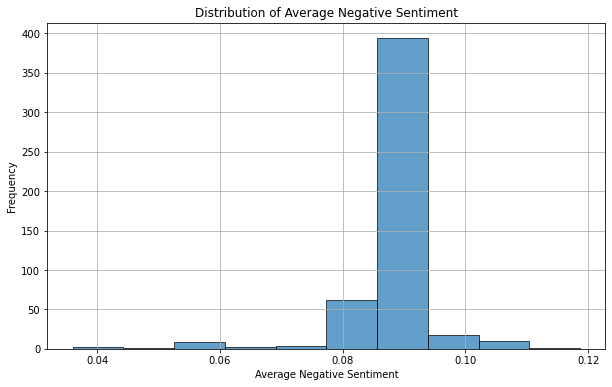

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns
# Dropping NaN values
cleaned_data = data['Average Negative Sentiment'].dropna()

# Plotting the distribution
plt.figure(figsize=(10, 6))
plt.hist(cleaned_data, bins=10, edgecolor='black', alpha=0.7)
plt.title('Distribution of Average Negative Sentiment')
plt.xlabel('Average Negative Sentiment')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [52]:

# Function to normalize and invert 'Average Negative Sentiment'
def normalize_and_invert_sentiment(df, column):
    # Ignore NaN values for normalization
    valid_values = df[column].dropna()

    # Normalize the values to a 0-5 scale
    min_val = valid_values.min()
    max_val = valid_values.max()
    normalized = 5 * (valid_values - min_val) / (max_val - min_val)

    # Invert the values
    inverted = 5 - normalized

    # Assign the inverted values back to the DataFrame
    df.loc[valid_values.index, 'Sentiment Star Rating'] = inverted

    # Replace NaN values with "no data"
    df['Sentiment Star Rating'].fillna("no data", inplace=True)

# Assuming your DataFrame is named 'data'
normalize_and_invert_sentiment(data, 'Average Negative Sentiment')

# Display the DataFrame to verify the changes
display(data[['Product Name', 'Average Negative Sentiment', 'Sentiment Star Rating']])


,Product Name,Average Negative Sentiment,Sentiment Star Rating
0,1st Financial Bank USA credit card,0.046333,4.375
1,Signature Cashback Rewards Credit Card,NaN,no data
2,Platinum+ Mastercard,0.087349,1.894201
3,Ally Platinum Mastercard_1,0.087349,1.894201
4,Ally Platinum Mastercard_2,0.087349,1.894201
...,...,...,...
643,Visa Cash Rewards,NaN,no data
644,Platinum Visa,NaN,no data
645,Visa Unicorn Credit Card,0.054750,3.865927
646,Visa Credit Card Platinum,NaN,no data


#Card Filtering Tool#

In [53]:
import ipywidgets as widgets
from IPython.display import display, clear_output
import pandas as pd

# Assuming 'data' is already defined as your DataFrame

# Global variable to store the filtered DataFrame
filtered_data = data.copy()

# Dropdown widget for credit tiers
credit_tier_dropdown = widgets.Dropdown(
    options=[
        'No credit score',
        'Credit score 619 or less',
        'Credit scores from 620 to 719',
        'Credit score of 720 or greater'
    ],
    value='No credit score',  # Default value
    description='',  # Remove the description
    disabled=False,
    layout={'width': 'max-content'}
)

# List of all state abbreviations
states = [
    'AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DE', 'FL', 'GA', 'HI', 'ID', 'IL', 'IN', 'IA',
    'KS', 'KY', 'LA', 'ME', 'MD', 'MA', 'MI', 'MN', 'MS', 'MO', 'MT', 'NE', 'NV', 'NH', 'NJ',
    'NM', 'NY', 'NC', 'ND', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VT',
    'VA', 'WA', 'WV', 'WI', 'WY'
]

# Dropdown widget for available states
states_dropdown = widgets.Dropdown(
    options=states,
    value='AL',  # Default value
    description='',  # Remove the description
    disabled=False,
    layout={'width': 'max-content'}
)

# List of possible card features
card_features = [
    'Chip card',
    'Contactless Payments',
    'Fee-free foreign transactions',
    'Mobile wallet provisioning (for example, Apple Pay)',
    'Other_features',
    'No_features'
]

# SelectMultiple widget for card features
features_dropdown = widgets.SelectMultiple(
    options=card_features,
    value=[],  # Default value
    description='',  # Remove the description
    disabled=False,
    layout={'width': 'max-content'}
)

# List of possible services
services = [
    'Access to Free Credit Scores',
    'Automobile rental insurance',
    'Credit card registration',
    'Debt cancellation coverage',
    'Discounts on purchases of goods and services (non travel related)',
    'Extension on manufacturer’s warranty',
    'Other_services',
    'No_Services'
]

# SelectMultiple widget for services
services_dropdown = widgets.SelectMultiple(
    options=services,
    value=[],  # Default value
    description='',  # Remove the description
    disabled=False,
    layout={'width': 'max-content'}
)

# List of possible rewards
rewards = [
    'Cashback rewards',
    'Other rewards',
    'Travel-related rewards',
    'No_rewards'
]

# SelectMultiple widget for rewards
rewards_dropdown = widgets.SelectMultiple(
    options=rewards,
    value=[],  # Default value
    description='',  # Remove the description
    disabled=False,
    layout={'width': 'max-content'}
)

# Output widget to display the filtered dataframe
output_filtered_data = widgets.Output()

# Label widget to display the number of rows in the filtered dataset
row_count_label = widgets.Label(value="Number of rows in the filtered dataset: 0")

# Global variable to store the final filtered dataset
final_filtered_data = pd.DataFrame()

# Function to filter the dataframe based on credit tier selection
def filter_by_credit_tier(change):
    global filtered_data, final_filtered_data
    if change['type'] == 'change' and change['name'] == 'value':
        with output_filtered_data:
            clear_output(wait=True)  # Clear the previous output
            selected_tier = credit_tier_dropdown.value
            filtered_data = data[data[selected_tier] == 1]
            # Update the final filtered data
            final_filtered_data = filtered_data.copy()
            # Display the filtered DataFrame
            display(filtered_data.head())
            # Update the row count label
            row_count_label.value = f"Number of rows in the filtered dataset: {len(filtered_data)}"

# Function to filter the dataframe based on selected state
def filter_by_state(change):
    global filtered_data, final_filtered_data
    if change['type'] == 'change' and change['name'] == 'value':
        with output_filtered_data:
            clear_output(wait=True)  # Clear the previous output
            selected_state = states_dropdown.value
            filtered_data = filtered_data[filtered_data['Available States'].apply(lambda x: selected_state in x)]
            # Update the final filtered data
            final_filtered_data = filtered_data.copy()
            # Display the filtered DataFrame
            display(filtered_data.head())
            # Update the row count label
            row_count_label.value = f"Number of rows in the filtered dataset: {len(filtered_data)}"

# Function to filter the dataframe based on selected features
def filter_by_features(change):
    global filtered_data, final_filtered_data
    if change['type'] == 'change' and change['name'] == 'value':
        with output_filtered_data:
            clear_output(wait=True)  # Clear the previous output
            selected_features = features_dropdown.value
            for feature in selected_features:
                filtered_data = filtered_data[filtered_data[feature] == 1]
            # Update the final filtered data
            final_filtered_data = filtered_data.copy()
            # Display the filtered DataFrame
            display(filtered_data.head())
            # Update the row count label
            row_count_label.value = f"Number of rows in the filtered dataset: {len(filtered_data)}"

# Function to filter the dataframe based on selected services
def filter_by_services(change):
    global filtered_data, final_filtered_data
    if change['type'] == 'change' and change['name'] == 'value':
        with output_filtered_data:
            clear_output(wait=True)  # Clear the previous output
            selected_services = services_dropdown.value
            for service in selected_services:
                filtered_data = filtered_data[filtered_data[service] == 1]
            # Update the final filtered data
            final_filtered_data = filtered_data.copy()
            # Display the filtered DataFrame
            display(filtered_data.head())
            # Update the row count label
            row_count_label.value = f"Number of rows in the filtered dataset: {len(filtered_data)}"

# Function to filter the dataframe based on selected rewards
def filter_by_rewards(change):
    global filtered_data, final_filtered_data
    if change['type'] == 'change' and change['name'] == 'value':
        with output_filtered_data:
            clear_output(wait=True)  # Clear the previous output
            selected_rewards = rewards_dropdown.value
            for reward in selected_rewards:
                filtered_data = filtered_data[filtered_data[reward] == 1]
            # Update the final filtered data
            final_filtered_data = filtered_data.copy()
            # Display the filtered DataFrame
            display(filtered_data.head())
            # Update the row count label
            row_count_label.value = f"Number of cards in the filtered dataset: {len(filtered_data)}"

# Watch for changes in the dropdown menus
credit_tier_dropdown.observe(filter_by_credit_tier, names='value')
states_dropdown.observe(filter_by_state, names='value')
features_dropdown.observe(filter_by_features, names='value')
services_dropdown.observe(filter_by_services, names='value')
rewards_dropdown.observe(filter_by_rewards, names='value')

# Arrange the dropdowns in a vertical box with labels properly displayed
ui = widgets.VBox([
    widgets.HBox([widgets.Label("Your Credit Tier:", layout={'width': '200px'}), credit_tier_dropdown]),
    widgets.HBox([widgets.Label("Your State:", layout={'width': '200px'}), states_dropdown]),
    widgets.HBox([widgets.Label("Card Features Requested:", layout={'width': '200px'}), features_dropdown]),
    widgets.HBox([widgets.Label("Card Services Requested:", layout={'width': '200px'}), services_dropdown]),
    widgets.HBox([widgets.Label("Card Rewards Requested:", layout={'width': '200px'}), rewards_dropdown]),
    row_count_label,
    output_filtered_data
])

# Display the UI
display(ui)


In [58]:
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets
from IPython.display import display, clear_output

# Output widget to display the graphs
output_graphs = widgets.Output()

# Function to create histograms for various APR values based on credit tier selection
def plot_apr_distributions(change):
    selected_tier = credit_tier_dropdown.value

    with output_graphs:
        clear_output(wait=True)  # Clear the previous output

        # Check if there is any data to plot
        if len(final_filtered_data) == 0:
            print("No data to display")
            return

        # Define APR columns based on credit tier selection
        if selected_tier in ['No credit score', 'Credit score 619 or less']:
            apr_columns = [
                ('Purchase APR min', 'Advance APR min')
            ]
        elif selected_tier == 'Credit scores from 620 to 719':
            apr_columns = [
                ('Purchase APR median', 'Advance APR median')
            ]
        elif selected_tier == 'Credit score of 720 or greater':
            apr_columns = [
                ('Purchase APR max', 'Advance APR max')
            ]
        else:
            print("Invalid selection")
            return

        fig, axs = plt.subplots(1, 2, figsize=(12, 6))

        for i, (col_purchase, col_advance) in enumerate(apr_columns):
            # Determine common x-axis limits for Purchase APR
            x_min_purchase = final_filtered_data[col_purchase].min()
            x_max_purchase = final_filtered_data[col_purchase].max()

            # Plot for Purchase APR
            sns.histplot(final_filtered_data[col_purchase], bins=30, ax=axs[0], kde=True, palette='viridis' )
            axs[0].set_title(f'Distribution of {col_purchase}')
            axs[0].set_xlabel('APR')
            axs[0].set_ylabel('Frequency')
            axs[0].set_xlim(x_min_purchase, x_max_purchase)

            # Determine common x-axis limits for Advance APR
            x_min_advance = final_filtered_data[col_advance].min()
            x_max_advance = final_filtered_data[col_advance].max()

            # Plot for Advance APR
            sns.histplot(final_filtered_data[col_advance], bins=30, ax=axs[1], kde=True, palette='BuPu')
            axs[1].set_title(f'Distribution of {col_advance}')
            axs[1].set_xlabel('APR')
            axs[1].set_ylabel('Frequency')
            axs[1].set_xlim(x_min_advance, x_max_advance)

        plt.tight_layout()
        plt.show()

# Display the plot button
plot_button = widgets.Button(description="Plot APR Distributions", disabled=False, button_style='', tooltip='Click to plot APR distributions', icon='bar-chart')

# Function to call the plot function on button click
def on_plot_button_click(b):
    plot_apr_distributions(None)

plot_button.on_click(on_plot_button_click)

# Display the plot button and output widget for graphs
display(plot_button, output_graphs)

# Watch for changes in the credit tier dropdown menu
credit_tier_dropdown.observe(plot_apr_distributions, names='value')


Button(description='Plot APR Distributions', icon='bar-chart', style=ButtonStyle(), tooltip='Click to plot APR…

Output()

In [55]:
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets
from IPython.display import display, clear_output

# Function to create subplots for Cumulative Yearly Fee, Balance Transfer Fee ($), and Balance Transfer Fee (%)
def plot_fee_distributions():
    with output_filtered_data:
        clear_output(wait=True)  # Clear the previous output

        # Exclude cards with a Cumulative Yearly Fee of 0
        yearly_fee_data = final_filtered_data[final_filtered_data['Cumulative Yearly Fee'] > 0]

        # Define the bins for Cumulative Yearly Fee
        bins = list(range(0, 100, 20)) + [100, 500]
        labels = ['1-20', '21-40', '41-60', '61-80', '81-100', '101-500']
        yearly_fee_data['Fee Bin'] = pd.cut(yearly_fee_data['Cumulative Yearly Fee'], bins=bins, labels=labels, right=False)

        # Exclude cards with a Balance Transfer Fee of 0$
        transfer_fee_dollar_data = final_filtered_data[final_filtered_data['Balance Transfer Fee ($)'] > 0]

        # Exclude cards with a Balance Transfer Fee of 0%
        transfer_fee_percentage_data = final_filtered_data[final_filtered_data['Balance Transfer Fee (%)'] > 0]

        # Create subplots
        fig, axs = plt.subplots(1, 3, figsize=(18, 6))

        # Plot for Cumulative Yearly Fee
        sns.countplot(data=yearly_fee_data, x='Fee Bin', palette='viridis', ax=axs[0])
        axs[0].set_title('Distribution of Cumulative Yearly Fee')
        axs[0].set_xlabel('Cumulative Yearly Fee Bins')
        axs[0].set_ylabel('Number of Cards')
        zero_fee_count = final_filtered_data['Cumulative Yearly Fee'].value_counts().get(0.0, 0)
        axs[0].annotate(f"{round(zero_fee_count/len(final_filtered_data)*100, 2)}% cards have no yearly fee.", xy=(0.5, -0.15), xycoords='axes fraction', ha='center', fontsize=12)

        # Plot for Balance Transfer Fee ($)
        sns.countplot(data=transfer_fee_dollar_data, x='Balance Transfer Fee ($)', order=sorted(transfer_fee_dollar_data['Balance Transfer Fee ($)'].unique()), palette='viridis', ax=axs[1])
        axs[1].set_title('Distribution of Balance Transfer Fee ($)')
        axs[1].set_xlabel('Balance Transfer Fee ($)')
        axs[1].set_ylabel('Number of Cards')
        zero_fee_dollar_count = final_filtered_data['Balance Transfer Fee ($)'].value_counts().get(0.0, 0)
        axs[1].annotate(f"{round(zero_fee_dollar_count/len(final_filtered_data)*100,2)}% cards have a $0 balance transfer fee.", xy=(0.5, -0.15), xycoords='axes fraction', ha='center', fontsize=12)

        # Plot for Balance Transfer Fee (%)
        sns.countplot(data=transfer_fee_percentage_data, x='Balance Transfer Fee (%)', order=sorted(transfer_fee_percentage_data['Balance Transfer Fee (%)'].unique()), palette='viridis', ax=axs[2])
        axs[2].set_title('Distribution of Balance Transfer Fee (%)')
        axs[2].set_xlabel('Balance Transfer Fee (%)')
        axs[2].set_ylabel('Number of Cards')
        zero_fee_percentage_count = final_filtered_data['Balance Transfer Fee (%)'].value_counts().get(0.00, 0)
        axs[2].annotate(f"{round(zero_fee_percentage_count/len(final_filtered_data)*100, 2)}% cards have a 0% balance transfer fee.", xy=(0.5, -0.15), xycoords='axes fraction', ha='center', fontsize=12)

        plt.tight_layout()
        plt.show()

# Display the plot button
plot_button = widgets.Button(description="Plot Fee Distributions", disabled=False, button_style='', tooltip='Click to plot fee distributions', icon='bar-chart')

# Function to call the plot function on button click
def on_plot_button_click(b):
    plot_fee_distributions()

plot_button.on_click(on_plot_button_click)

# Display the plot button
display(plot_button, output_filtered_data)

Button(description='Plot Fee Distributions', icon='bar-chart', style=ButtonStyle(), tooltip='Click to plot fee…

Output()

In [59]:
import ipywidgets as widgets
from IPython.display import display, clear_output
import pandas as pd

# Dropdown widget for sorting options
sorting_dropdown1 = widgets.Dropdown(
    options=['None'] + [
        'Advance APR median',
        'Purchase APR median',
        'Intro APR median',
        'Cumulative Yearly Fee'
    ],
    value='None',  # Default value
    description='',
    disabled=False,
    layout={'width': '200px'}  # Adjust the width of the dropdown itself
)

# Custom label for the dropdown
sorting_label = widgets.Label("Sort by (low -> high):")

# Output widget to display the sorted dataframe
output_top = widgets.Output()

# Global variable to store the sorted DataFrame
sorted_data = pd.DataFrame()

# Function to sort the dataframe based on the selected metric
def sort_dataframe(change):
    global final_filtered_data, sorted_data
    selected_metric1 = sorting_dropdown1.value
    with output_top:
        clear_output(wait=True)  # Clear the previous output
        if selected_metric1 != 'None':
            sorted_data = final_filtered_data.sort_values(by=selected_metric1)
        else:
            sorted_data = final_filtered_data.copy()

        # Replace final_filtered_data with the sorted dataframe
        final_filtered_data = sorted_data.copy()

        display(final_filtered_data[['Institution Name', 'Product Name', 'Advance APR median', 'Purchase APR median', 'Intro APR median',
                                     'Cumulative Yearly Fee', 'Other Periodic Fees Cumulative', 'Fee Explanation',
                                     'Balance Transfer Fees Cumulative', 'Cash Advance Fees Cumulative',
                                     'Foreign Transaction Fees Cumulative', 'Late Fee Cumulative',
                                     'Over Limit Fee Cumulative', 'Website for Consumer']])

# Watch for changes in the dropdown menu
sorting_dropdown1.observe(sort_dataframe, names='value')

# Display the dropdown menu and output widget
display(widgets.HBox([sorting_label, sorting_dropdown1]), output_top)


Output()

In [60]:
import ipywidgets as widgets
from IPython.display import display, clear_output, HTML
import pandas as pd

# Function to convert numeric score to star symbols
def convert_to_stars(score):
    if isinstance(score, (int, float)):
        full_stars = int(score)
        half_star = (score - full_stars) >= 0.5
        stars = '★' * full_stars + ('½' if half_star else '')
        return stars
    return "no data"

# Function to display detailed information about the top card
def display_top_card_info():
    with output_top:
        clear_output(wait=True)
        if len(final_filtered_data) == 0:
            print("No data available")
            return

        top_card = final_filtered_data.iloc[0]

        def get_value(column):
            return top_card[column] if pd.notna(top_card[column]) else "no data"

        sentiment_stars = convert_to_stars(top_card['Sentiment Star Rating'])

        display(HTML(f"""
        <h1>{get_value('Institution Name')}</h1>
        <h2>{get_value('Product Name')}</h2>
        <p><b>Advance APR median:</b> {get_value('Advance APR median')}</p>
        <ul><li>The median annual percentage rate (APR) charged on cash advances taken with a credit card, indicating the typical interest rate applied to these transactions.</li></ul>
        <p><b>Purchase APR median:</b> {get_value('Purchase APR median')}</p>
        <ul><li>The median annual percentage rate (APR) applied to purchases made with a credit card, representing the standard interest rate most cardholders experience for their purchases.</li></ul>
        <p><b>Intro APR median:</b> {get_value('Intro APR median')}</p>
        <ul><li>The median introductory annual percentage rate (APR) offered to new credit cardholders for a limited time, often lower than the regular APR to attract new customers.</li></ul>
        <hr>
        <p><b>Cumulative Yearly Fee:</b> {get_value('Cumulative Yearly Fee')}</p>
        <ul><li>The total annual fee charged by a credit card issuer, which may include membership fees or other recurring charges applicable over the course of a year.</li></ul>
        <p><b>Other Periodic Fees Cumulative:</b> {get_value('Other Periodic Fees Cumulative')}</p>
        <ul><li>The total amount of various recurring fees other than the annual fee, such as monthly service charges or account maintenance fees, accumulated over a specified period.</li></ul>
        <p><b>Fee Explanation:</b> {get_value('Fee Explanation')}</p>
        <hr>
        <p><b>Balance Transfer Fees Cumulative:</b> {get_value('Balance Transfer Fees Cumulative')}</p>
        <ul><li>The total fees incurred when transferring a balance from one credit card to another, accumulated over a certain period.</li></ul>
        <p><b>Cash Advance Fees Cumulative:</b> {get_value('Cash Advance Fees Cumulative')}</p>
        <ul><li>The total fees charged for taking cash advances using a credit card, accumulated over a specific timeframe.</li></ul>
        <p><b>Foreign Transaction Fees Cumulative:</b> {get_value('Foreign Transaction Fees Cumulative')}</p>
        <ul><li>The total fees charged for making purchases in foreign currencies or with foreign merchants, accumulated over a certain period.</li></ul>
        <p><b>Late Fee Cumulative:</b> {get_value('Late Fee Cumulative')}</p>
        <ul><li>The total fees charged for making late payments on a credit card, accumulated over a specified timeframe.</li></ul>
        <p><b>Over Limit Fee Cumulative:</b> {get_value('Over Limit Fee Cumulative')}</p>
        <ul><li>The total fees charged for exceeding the credit limit on a credit card, accumulated over a certain period.</li></ul>
        <hr>
        <p><b>Sentiment Star Rating:</b> {sentiment_stars}</p>
        <ul><li>This 0-5 star rating reflects the average customer sentiment towards this card provided based on current customer complaints submitted to the CFPB.</li></ul>
        <p><b>Issue Summary:</b> {get_value('Issue Summary')}</p>
        <ul><li>These phrases indicate the most common issues customers raised to the CFPB about the card in question</li></ul>
        <hr>
        <p><b>Website for Consumer:</b> <a href="{get_value('Website for Consumer')}" target="_blank">{get_value('Website for Consumer')}</a></p>
        """))

# Output widget to display the card information
output_top = widgets.Output()

# Display the button to show the top card information
top_card_button = widgets.Button(
    description="Show Top Card Info",
    disabled=False,
    button_style='',
    tooltip='Click to display top card information',
    icon='info',
    layout=widgets.Layout(width='250px')  # Adjust the width as needed
)

# Function to call the display function on button click
def on_top_card_button_click(b):
    display_top_card_info()

top_card_button.on_click(on_top_card_button_click)

# Display the button and output widget
display(top_card_button, output_top)


Button(description='Show Top Card Info', icon='info', layout=Layout(width='250px'), style=ButtonStyle(), toolt…

Output()